In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import datasets

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Online data vs batch for limited initial training data

We will investigate a scenario where we train an initial batch model and online model to a small data set, and then observe accuracy over time as we score new points. The online model will be updated with the new samples, whereas the batch model will not.

We will use the digits dataset for this exercise- we have 1797 samples, and the objective is to classify the digit.

In [2]:
digits = datasets.load_digits()
X, y = digits.data, digits.target

## Define a generator to produce batches of data

We do this to give us flexibility to produce batches of different sizes should we want to investigate this scenario in more detail. The generator produces indices for us to slice the feature and outcome arrays.

In [3]:
class GenIndex(object):
    def __init__(self, shape, n_folds, seed=1234):
        self.shape = shape
        self.n_folds = n_folds
        self.seed = seed
        self.gen = self._gen()
        
    def _gen(self):
        np.random.seed(seed = self.seed)
        ix = np.arange(self.shape)
        np.random.shuffle(ix)
        ix = np.array_split(ix, self.n_folds)
        for _ in ix:
            yield _
    
    def next_batch(self):
        '''
        returns indices we can use to subset our data
        '''
        try:
            return next(self.gen)
        except:
            return np.array([False])

In [4]:
# we will split the dataset into 20 batches. The first will be used to train
# our batch model and initial online model
nbatch = 20
gen = GenIndex(X.shape[0], nbatch)
inital_batch_ix = gen.next_batch()

X_initial, y_initial = X[inital_batch_ix, :], y[inital_batch_ix]

## Train initial SGD model

In [5]:
# scale the data: SGD models can become unstable
# when converging if data not scaled
scale = StandardScaler(with_mean = True, with_std = True)
scale.fit(X_initial)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
# initialise SGDCLassifier object
sgd_est = SGDClassifier(loss = 'log',
                        penalty = 'l1',
                        max_iter = 500,
                        random_state = 1234,
                        warm_start= False)

# candidate hyperparameters
sgd_param_grid = dict(alpha = [0.001, 0.01, 0.1, 1, 10],
                      eta0 = [0.001, 0.01, 0.1, 1, 10],
                      l1_ratio = [0., 0.15 ,0.25, 0.5, 0.75],
                      learning_rate = ['optimal', 'constant'] 
                      )

# initialise GridSearchCV object
grid_search_sgd = GridSearchCV(estimator = sgd_est,
                              param_grid = sgd_param_grid,
                              scoring = 'accuracy',
                              n_jobs = 3,
                              cv = 3,
                              refit = True,
                              verbose = 1)

# fit model
grid_search_sgd.fit(scale.transform(X_initial), y_initial);

Fitting 3 folds for each of 250 candidates, totalling 750 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   14.9s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   36.0s
[Parallel(n_jobs=3)]: Done 750 out of 750 | elapsed:  1.0min finished


In [9]:
print('Chosen params: {}\n\nTrain Accuracy: {:0.3f}'.format(grid_search_sgd.best_params_,
                                                        grid_search_sgd.best_score_))

# extract best model
sgd_cls =  grid_search_sgd.best_estimator_

Chosen params: {'alpha': 0.001, 'eta0': 0.1, 'l1_ratio': 0.0, 'learning_rate': 'constant'}

Train Accuracy: 0.900


## Train logistic regression model



In [10]:
# initialise object
lr_est = LogisticRegression()

# candidate hyperparameters
lr_param_grid = dict(penalty = ['l1', 'l2'],
                     C = [0.001, 0.01, 0.1, 1, 10])

# initialise GridSearchCV object
grid_search_lr = GridSearchCV(estimator = lr_est,
                              param_grid = lr_param_grid,
                              scoring = 'accuracy',
                              n_jobs = 3,
                              cv = 3,
                              refit = True,
                              verbose = 1)

# fit the model
grid_search_lr.fit(scale.transform(X_initial), y_initial);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:    0.1s finished


In [11]:
print('Chosen params: {}\n\nTrain Accuracy: {:0.3f}'.format(grid_search_lr.best_params_,
                                                        grid_search_lr.best_score_))

# extract model
lr_cls =  grid_search_lr.best_estimator_

Chosen params: {'C': 10, 'penalty': 'l1'}

Train Accuracy: 0.900


## Compare the models as we gain more data

We see initial performance of the two models is comparable from our cross validation results. We are interested to see if the online model improves as more data is gathered and the decision function is updated.

However, if the initial data contains enough information for the batch (logistic regression) model to train well, we would expect it to perform better: we would never expect a SGD model to converge as well as a standard logistic regression model

In [12]:
# initialise empty array for holding results.
# remember we initialised the models on the first batch
update_result = np.empty((nbatch - 1, 3))

In [13]:
i = 0
while True:    
    # get next batch
    batch_ix = gen.next_batch()
    if any(batch_ix):
        pass
    else:
        break
        
    features, outcome = X[batch_ix, :], y[batch_ix]
    
    # scale features
    features = scale.transform(features)

    # predict
    pred = sgd_cls.predict(features)
    pred_lr = lr_cls.predict(features)

    # assess accuracy
    acc = np.sum(pred == outcome) / len(pred)
    acc_lr = np.sum(pred_lr == outcome) / len(pred_lr)
    
    update_result[i, 0] = i + 1
    update_result[i, 1] = acc
    update_result[i, 2] = acc_lr

    # update model
    if i == 0:
        sgd_cls.partial_fit(features, outcome, classes=np.unique(y[batch_ix]))
    else:
        sgd_cls.partial_fit(features, outcome)
    i += 1


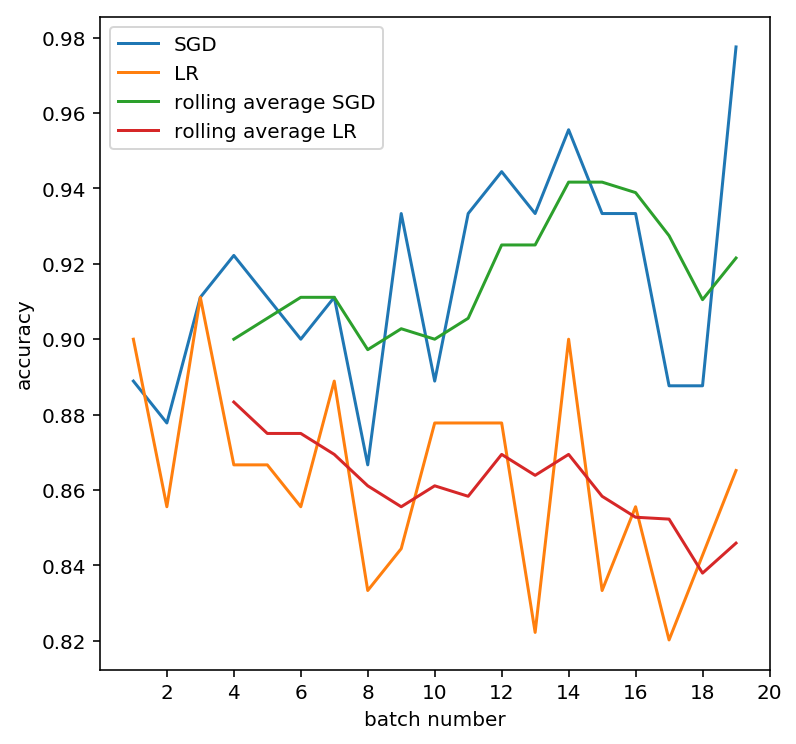

In [14]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N])/ float(N)

# look at cumulative accuracy as well

fig, ax = plt.subplots(1, 1, figsize = (6,6))

i = update_result[:, 0]
acc_sgd = update_result[:, 1]
acc_lr = update_result[:, 2]
ax.plot(i, acc_sgd, label='SGD')
ax.plot(i, acc_lr, label='LR')
ax.plot(i[3:], running_mean(acc_sgd, 4), label = 'rolling average SGD')
ax.plot(i[3:], running_mean(acc_lr, 4), label = 'rolling average LR')

ax.legend()
ax.set_xlabel('batch number')
ax.set_ylabel('accuracy')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.set_xticks(np.arange(2,22,2))
ax.set_xlim(0, 20);

## Summary

We caveat that the data set is relatively small, and ideally we would want to examine over more batches. However, the results strongly suggest that the performance of the online model pulls away from that of the batch trained model as we see more data.

Many areas to investigate remain. I would be interested to know what happens once the performance of the online model performance peaks? Would we then want to reduce the weights when we update? Or would we decide to stop updating altogether?